In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pathlib import Path


# Build robust path to data folder (notebooks and data are siblings)
DATA_DIR = Path.cwd().parent / 'data'
SUB_DIR = Path.cwd().parent / 'submissions'
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'


# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)  # This is for final predictions (no 'W' column)

# Display basic information about the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"'W' column in train dataset: {'W' in train_df.columns}")
print(f"'W' column in test dataset: {'W' in test_df.columns}")

Training set shape: (1812, 51)
Test set shape: (453, 45)
'W' column in train dataset: True
'W' column in test dataset: False


In [2]:
# Create derived features for both train and test sets

# R_per_game: Runs per game
# RA_per_game: Runs allowed per game
train_df['R_per_game'] = train_df['R'] / train_df['G']
train_df['RA_per_game'] = train_df['RA'] / train_df['G']
test_df['R_per_game'] = test_df['R'] / test_df['G']
test_df['RA_per_game'] = test_df['RA'] / test_df['G']

print(f"\nCreated derived features: R_per_game, RA_per_game")
print(f"Train - R_per_game range: {train_df['R_per_game'].min():.3f} to {train_df['R_per_game'].max():.3f}")
print(f"Train - RA_per_game range: {train_df['RA_per_game'].min():.3f} to {train_df['RA_per_game'].max():.3f}")
print(f"Test - R_per_game range: {test_df['R_per_game'].min():.3f} to {test_df['R_per_game'].max():.3f}")
print(f"Test - RA_per_game range: {test_df['RA_per_game'].min():.3f} to {test_df['RA_per_game'].max():.3f}")

# Expected Wins of Season = G × (R²) / (R² + RA²)
train_df['Expected_Wins'] = train_df['G'] * (train_df['R_per_game'] ** 2) / ((train_df['R_per_game'] ** 2) + (train_df['RA_per_game'] ** 2))
test_df['Expected_Wins'] = test_df['G'] * (test_df['R_per_game'] ** 2) / ((test_df['R_per_game'] ** 2) + (test_df['RA_per_game'] ** 2))
# train_df['Expected_Wins'] = train_df['G'] * (train_df['R'] ** 2) / ((train_df['R'] ** 2) + (train_df['RA'] ** 2))
# test_df['Expected_Wins'] = test_df['G'] * (test_df['R'] ** 2) / ((test_df['R'] ** 2) + (test_df['RA'] ** 2))
print(f"\nCreated derived feature: Expected_Wins")   
print(f"Train - Expected_Wins range: {train_df['Expected_Wins'].min():.3f} to {train_df['Expected_Wins'].max():.3f}")
print(f"Test - Expected_Wins range: {test_df['Expected_Wins'].min():.3f} to {test_df['Expected_Wins'].max():.3f}")

# Times getting on base
train_df['Times_On_Base'] = train_df['H'] + train_df['BB']
test_df['Times_On_Base'] = test_df['H'] + test_df['BB']

print(f"\nCreated derived feature: Times_On_Base")
print(f"Train - Times_On_Base range: {train_df['Times_On_Base'].min():.3f} to {train_df['Times_On_Base'].max():.3f}")
print(f"Test - Times_On_Base range: {test_df['Times_On_Base'].min():.3f} to {test_df['Times_On_Base'].max():.3f}")

# BB Rate (Walk Percentage) - BB / AB + BB
train_df['BB_Rate'] = train_df['BB'] / (train_df['AB'] + train_df['BB'])
test_df['BB_Rate'] = test_df['BB'] / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: BB_Rate")
print(f"Train - BB_Rate range: {train_df['BB_Rate'].min():.3f} to {train_df['BB_Rate'].max():.3f}") 
print(f"Test - BB_Rate range: {test_df['BB_Rate'].min():.3f} to {test_df['BB_Rate'].max():.3f}")

# Home Run Rate - HR / AB
train_df['HR_Rate'] = train_df['HR'] / train_df['AB']
test_df['HR_Rate'] = test_df['HR'] / test_df['AB']

print(f"\nCreated derived feature: HR_Rate")
print(f"Train - HR_Rate range: {train_df['HR_Rate'].min():.3f} to {train_df['HR_Rate'].max():.3f}")
print(f"Test - HR_Rate range: {test_df['HR_Rate'].min():.3f} to {test_df['HR_Rate'].max():.3f}")

# On-Base Percentage (OBP) - (H + BB) / (AB + BB)
train_df['OBP'] = (train_df['H'] + train_df['BB']) / (train_df['AB'] + train_df['BB'])
test_df['OBP'] = (test_df['H'] + test_df['BB']) / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: OBP")
print(f"Train - OBP range: {train_df['OBP'].min():.3f} to {train_df['OBP'].max():.3f}") 
print(f"Test - OBP range: {test_df['OBP'].min():.3f} to {test_df['OBP'].max():.3f}")

# Slugging Percentage (SLG)
# Singles = H - (2B + 3B + HR)
# Total Bases = Singles + (2 * 2B) + (3 * 3B) + (4 * HR)
# SLG = Total Bases / AB
Singles_train = train_df['H'] - (train_df['2B'] + train_df['3B'] + train_df['HR'])
Total_Bases_train = Singles_train + (2 * train_df['2B']) + (3 * train_df['3B']) + (4 * train_df['HR'])
train_df['SLG'] = Total_Bases_train / train_df['AB']  

Singles_test = test_df['H'] - (test_df['2B'] + test_df['3B'] + test_df['HR'])
Total_Bases_test = Singles_test + (2 * test_df['2B']) + (3 * test_df['3B']) + (4 * test_df['HR'])
test_df['SLG'] = Total_Bases_test / test_df['AB']

print(f"\nCreated derived feature: SLG")
print(f"Train - SLG range: {train_df['SLG'].min():.3f} to {train_df['SLG'].max():.3f}") 
print(f"Test - SLG range: {test_df['SLG'].min():.3f} to {test_df['SLG'].max():.3f}")    

# Combined On-Base Plus Slugging (OPS) - OBP + SLG
train_df['OPS'] = train_df['OBP'] + train_df['SLG']
test_df['OPS'] = test_df['OBP'] + test_df['SLG']

print(f"\nCreated derived feature: OPS")
print(f"Train - OPS range: {train_df['OPS'].min():.3f} to {train_df['OPS'].max():.3f}") 
print(f"Test - OPS range: {test_df['OPS'].min():.3f} to {test_df['OPS'].max():.3f}")

# Time on Base Allowed - HA + BBA
train_df['Times_On_Base_Allowed'] = train_df['HA'] + train_df['BBA']
test_df['Times_On_Base_Allowed'] = test_df['HA'] + test_df['BBA']

print(f"\nCreated derived feature: Times_On_Base_Allowed")
print(f"Train - Times_On_Base_Allowed range: {train_df['Times_On_Base_Allowed'].min():.3f} to {train_df['Times_On_Base_Allowed'].max():.3f}")
print(f"Test - Times_On_Base_Allowed range: {test_df['Times_On_Base_Allowed'].min():.3f} to {test_df['Times_On_Base_Allowed'].max():.3f}")

# WHIP (Walks plus Hits per Inning Pitched)
# Inings Pitched = IPouts / 3
# Times_On_Base_Per_Inning = Times_On_Base_Allowed / Inings_Pitched
train_df['Innings_Pitched'] = train_df['IPouts'] / 3
train_df['WHIP'] = train_df['Times_On_Base_Allowed'] / train_df['Innings_Pitched']
test_df['Innings_Pitched'] = test_df['IPouts'] / 3
test_df['WHIP'] = test_df['Times_On_Base_Allowed'] / test_df['Innings_Pitched']

print(f"\nCreated derived feature: WHIP")
print(f"Train - WHIP range: {train_df['WHIP'].min():.3f} to {train_df['WHIP'].max():.3f}")
print(f"Test - WHIP range: {test_df['WHIP'].min():.3f} to {test_df['WHIP'].max():.3f}")

# K/9 (Strikeouts per 9 Innings) - SOA / Innings_Pitched * 9
train_df['K_per_9'] = (train_df['SOA'] / train_df['Innings_Pitched']) * 9
test_df['K_per_9'] = (test_df['SOA'] / test_df['Innings_Pitched']) * 9  

print(f"\nCreated derived feature: K_per_9")
print(f"Train - K_per_9 range: {train_df['K_per_9'].min():.3f} to {train_df['K_per_9'].max():.3f}")
print(f"Test - K_per_9 range: {test_df['K_per_9'].min():.3f} to {test_df['K_per_9'].max():.3f}")

# HR/9 (Home Runs Allowed per 9 Innings) - HRA / Innings_Pitched * 9
train_df['HR_per_9'] = (train_df['HRA'] / train_df['Innings_Pitched']) * 9
test_df['HR_per_9'] = (test_df['HRA'] / test_df['Innings_Pitched']) * 9

print(f"\nCreated derived feature: HR_per_9")
print(f"Train - HR_per_9 range: {train_df['HR_per_9'].min():.3f} to {train_df['HR_per_9'].max():.3f}")
print(f"Test - HR_per_9 range: {test_df['HR_per_9'].min():.3f} to {test_df['HR_per_9'].max():.3f}")



Created derived features: R_per_game, RA_per_game
Train - R_per_game range: 2.409 to 6.884
Train - RA_per_game range: 2.458 to 7.686
Test - R_per_game range: 2.783 to 6.896
Test - RA_per_game range: 2.867 to 6.865

Created derived feature: Expected_Wins
Train - Expected_Wins range: 35.860 to 119.963
Test - Expected_Wins range: 40.352 to 107.111

Created derived feature: Times_On_Base
Train - Times_On_Base range: 1367.000 to 2415.000
Test - Times_On_Base range: 1453.000 to 2327.000

Created derived feature: BB_Rate
Train - BB_Rate range: 0.051 to 0.136
Test - BB_Rate range: 0.052 to 0.123

Created derived feature: HR_Rate
Train - HR_Rate range: 0.001 to 0.047
Test - HR_Rate range: 0.001 to 0.045

Created derived feature: OBP
Train - OBP range: 0.262 to 0.382
Test - OBP range: 0.267 to 0.382

Created derived feature: SLG
Train - SLG range: 0.274 to 0.491
Test - SLG range: 0.261 to 0.488

Created derived feature: OPS
Train - OPS range: 0.539 to 0.870
Test - OPS range: 0.530 to 0.870

Cre

In [3]:
# Select only the default features from DATA_DESCRIPTION.md
# default_features = [
#     # Basic Statistics
#     'G', 'HR', 'SHO', 'SV', 'IPouts', 'FP', 'ERA', 'ER', 'E',

#     # Derived Features
#     'Expected_Wins', 'Times_On_Base', 'BB_Rate', 'HR_Rate', 'OPS', 'Times_On_Base_Allowed', 
#     'WHIP', 'K_per_9', 'HR_per_9', 'mlb_rpg',
    
#     # Era Indicators
#     'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
#     # Decade Indicators
#     'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
#     'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
# ]

default_features = [
    # Basic Statistics
    'G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
    'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
    'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
    
    # Derived Features
    'Expected_Wins', 'WHIP', 'OBP', 'SLG', 'OPS', 'K_per_9', 'HR_per_9', 'BB_Rate', 'HR_Rate',
    'Times_On_Base', 'Times_On_Base_Allowed', 'mlb_rpg',
    
    # Era Indicators
    'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
    # Decade Indicators
    'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
 ]

# Filter features that exist in both training data AND test data
available_features = [col for col in default_features 
                     if col in train_df.columns and col in test_df.columns]
print(f"Number of available default features: {len(available_features)}")

# Print available features in a column
print("Available features:")
for feature in available_features:
    print(feature)


Number of available default features: 55
Available features:
G
R
AB
H
2B
3B
HR
BB
SO
SB
RA
ER
ERA
CG
SHO
SV
IPouts
HA
HRA
BBA
SOA
E
DP
FP
Expected_Wins
WHIP
OBP
SLG
OPS
K_per_9
HR_per_9
BB_Rate
HR_Rate
Times_On_Base
Times_On_Base_Allowed
mlb_rpg
era_1
era_2
era_3
era_4
era_5
era_6
era_7
era_8
decade_1910
decade_1920
decade_1930
decade_1940
decade_1950
decade_1960
decade_1970
decade_1980
decade_1990
decade_2000
decade_2010


In [4]:
# Prepare training data (split the train.csv for model evaluation)
X_full = train_df[available_features]
y_full = train_df['W']

# Split training data into train/validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Prepare final test data for predictions (this has no target variable)
X_test_final = test_df[available_features]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Final test set shape: {X_test_final.shape}")

Training set shape: (1449, 55)
Validation set shape: (363, 55)
Final test set shape: (453, 55)


In [5]:
# Import boosting libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
import time
import warnings

# Silence XGBoost FutureWarnings about deprecated pandas functions
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

print("BOOSTING MODELS COMPARISON")
print("="*50)

# Prepare data
X = X_full
y = y_full

print(f"\nDataset shape: {X.shape}")
print(f"Features being used: {list(X.columns)}")

# Define models with GPU acceleration where available
models = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0,
        tree_method="hist",
        device="cuda"  # 🚀 GPU acceleration 
    ),
    
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        device='cuda'  # 🚀 GPU acceleration 
    ),
    
    'CatBoost': CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=False,
        task_type="GPU"  # 🚀 GPU acceleration 
    )
}

# Cross-validation
cv_results = {}

for name, model in models.items():
    print(f"\nTesting {name}...")
    start_time = time.time()
    
    try:
        # Get both R² and MAE
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            verbose=0
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '✅ GPU'
        }
        
    except Exception as e:
        print(f"   ⚠️ GPU failed, falling back to CPU: {str(e)}")
        # Fallback to CPU version
        if name == 'XGBoost':
            model.set_params(device="cpu")
        elif name == 'LightGBM':
            model.set_params(device="cpu")
        elif name == 'CatBoost':
            model.set_params(task_type="CPU")
            
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            verbose=0
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '⚠️ CPU fallback'
        }

# Display results
print(f"\n{'Model':<12} {'Test R²':<10} {'Test MAE':<10} {'Overfitting':<12} {'Time (s)':<10} {'GPU Status':<15}")
print("-" * 90)

for name, results in sorted(cv_results.items(), key=lambda x: x[1]['test_r2'], reverse=True):
    print(f"{name:<12} {results['test_r2']:.4f}    {results['test_mae']:.2f}      {results['overfitting']:.4f}      {results['time']:.1f}      {results['gpu_status']}")

# Feature importance for best model
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['test_r2'])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Training {best_model_name} on full dataset for feature importance...")

best_model.fit(X, y)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features from {best_model_name}:")
    print("-" * 40)
    for i, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:>20}: {row['importance']:.4f}")


BOOSTING MODELS COMPARISON

Dataset shape: (1812, 55)
Features being used: ['G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'Expected_Wins', 'WHIP', 'OBP', 'SLG', 'OPS', 'K_per_9', 'HR_per_9', 'BB_Rate', 'HR_Rate', 'Times_On_Base', 'Times_On_Base_Allowed', 'mlb_rpg', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8', 'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010']

Testing XGBoost...

Testing LightGBM...

Testing CatBoost...

Model        Test R²    Test MAE   Overfitting  Time (s)   GPU Status     
------------------------------------------------------------------------------------------
CatBoost     0.9132    3.06      0.0549      5.1      ✅ GPU
LightGBM     0.9071    3.16      0.0913      12.7      ✅ GPU
XGBoost      0.9065    3.16      0.0921     

In [6]:
print("LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES")
print("="*70)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
import time

# Prepare data
X_linear = X_full
y = y_full

print(f"Dataset shape: {X_linear.shape}")
print(f"Using {len(available_features)} engineered features\n")

# Define linear models with pipelines (include scaling)
models_linear = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    
    'Ridge (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.1))
    ]),
    
    'Ridge (alpha=1.0)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    
    'Ridge (alpha=10)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ]),
    
    'Lasso (alpha=0.01)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.01, max_iter=5000))
    ]),
    
    'Lasso (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=5000))
    ]),
    
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
    ]),
       
    'Huber Regressor': Pipeline([
        ('scaler', StandardScaler()),
        ('model', HuberRegressor(
            epsilon=1.35, 
            max_iter=2000,  # 🔧 Increased from 1000 to 2000
            alpha=0.0001,   # 🔧 Added regularization
            tol=1e-05       # 🔧 Adjusted tolerance
        ))
    ]),

    'Polynomial Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ])
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results_linear = {}

# Test all models
for name, model in models_linear.items():
    print(f"Testing {name}...")
    start_time = time.time()
    
    try:
        cv_scores = cross_validate(
            model, X_linear, y,
            cv=cv,
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            error_score='raise'
        )
        
        end_time = time.time()
        
        results_linear[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'status': 'Success'
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        results_linear[name] = {'status': 'Failed', 'error': str(e)}

print("\n" + "="*90)
print("RESULTS SUMMARY")
print("="*90)
print(f"{'Model':<22} {'Test R²':<10} {'Test MAE':<11} {'Overfitting':<13} {'Time (s)':<10}")
print("-" * 90)

# Sort by Test R²
successful_results = {k: v for k, v in results_linear.items() if v.get('status') == 'Success'}
sorted_results = sorted(successful_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

for name, result in sorted_results:
    overfit_warning = "⚠️" if result['overfitting'] > 0.05 else "✓"
    print(f"{name:<22} {result['test_r2']:.4f}    {result['test_mae']:.2f}       "
          f"{result['overfitting']:>6.4f} {overfit_warning:<5} {result['time']:>6.1f}")

# Identify best model
if sorted_results:
    best_model_name = sorted_results[0][0]
    best_score = sorted_results[0][1]['test_r2']
    best_mae = sorted_results[0][1]['test_mae']
    
    print(f"\n🏆 Best Linear Model: {best_model_name}")
    print(f"   CV R² = {best_score:.4f} (±{sorted_results[0][1]['test_r2_std']:.4f})")
    print(f"   CV MAE = {best_mae:.2f} wins (±{sorted_results[0][1]['test_mae_std']:.2f})")

LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES
Dataset shape: (1812, 55)
Using 55 engineered features

Testing Linear Regression...
Testing Ridge (alpha=0.1)...
Testing Ridge (alpha=1.0)...
Testing Ridge (alpha=10)...
Testing Lasso (alpha=0.01)...
Testing Lasso (alpha=0.1)...
Testing Elastic Net...
Testing Huber Regressor...
Testing Polynomial Ridge...

RESULTS SUMMARY
Model                  Test R²    Test MAE    Overfitting   Time (s)  
------------------------------------------------------------------------------------------
Lasso (alpha=0.01)     0.9314    2.72       0.0041 ✓        0.1
Ridge (alpha=1.0)      0.9312    2.72       0.0047 ✓        0.0
Ridge (alpha=0.1)      0.9311    2.73       0.0050 ✓        0.0
Ridge (alpha=10)       0.9309    2.73       0.0042 ✓        0.0
Linear Regression      0.9305    2.74       0.0053 ✓        0.1
Huber Regressor        0.9305    2.74       0.0055 ✓        0.7
Polynomial Ridge       0.9240    2.86       0.0264 ✓        0.4
Elastic Net    

In [7]:
print("LASSO HYPERPARAMETER TUNING")
print("="*50)

from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Setup the Lasso pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=5000))
])

# Define parameter grid for comprehensive tuning
# Focus on alpha values around the current best (0.01) and explore nearby values
param_grid = {
    'lasso__alpha': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
}

print(f"Testing {len(param_grid['lasso__alpha'])} alpha values...")
print(f"Lasso alpha values: {param_grid['lasso__alpha']}")

# Perform grid search with cross-validation (using multiple scoring metrics)
from sklearn.model_selection import cross_validate

grid_search_lasso = GridSearchCV(
    lasso_pipeline,
    param_grid,
    cv=5,
    scoring=['r2', 'neg_mean_absolute_error'],
    refit='r2',  # Use R² as primary metric for selecting best model
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
print("\nPerforming grid search...")
grid_search_lasso.fit(X_full, y_full)

# Display results
print(f"\n🏆 BEST PARAMETERS (based on R²):")
print(f"   Lasso alpha: {grid_search_lasso.best_params_['lasso__alpha']}")
print(f"   Best CV R²: {grid_search_lasso.best_score_:.4f}")

# Get MAE for the best model
best_mae_score_lasso = -grid_search_lasso.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_lasso.best_index_]
best_mae_std_lasso = grid_search_lasso.cv_results_['std_test_neg_mean_absolute_error'][grid_search_lasso.best_index_]
print(f"   Best CV MAE: {best_mae_score_lasso:.2f} (±{best_mae_std_lasso:.2f}) wins")

# Compare with original Lasso (alpha=0.01)
original_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01, max_iter=5000))
])

# Quick comparison with both metrics
original_cv_results_lasso = cross_validate(original_lasso, X_full, y_full, cv=5, 
                                          scoring=['r2', 'neg_mean_absolute_error'])
tuned_cv_results_lasso = cross_validate(grid_search_lasso.best_estimator_, X_full, y_full, cv=5, 
                                       scoring=['r2', 'neg_mean_absolute_error'])

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   Original Lasso (α=0.01):")
print(f"     R²: {original_cv_results_lasso['test_r2'].mean():.4f} (±{original_cv_results_lasso['test_r2'].std():.4f})")
print(f"     MAE: {-original_cv_results_lasso['test_neg_mean_absolute_error'].mean():.2f} (±{original_cv_results_lasso['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Tuned Lasso:")
print(f"     R²: {tuned_cv_results_lasso['test_r2'].mean():.4f} (±{tuned_cv_results_lasso['test_r2'].std():.4f})")
print(f"     MAE: {-tuned_cv_results_lasso['test_neg_mean_absolute_error'].mean():.2f} (±{tuned_cv_results_lasso['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Improvement:")
print(f"     R²: {tuned_cv_results_lasso['test_r2'].mean() - original_cv_results_lasso['test_r2'].mean():.4f}")
print(f"     MAE: {-tuned_cv_results_lasso['test_neg_mean_absolute_error'].mean() - (-original_cv_results_lasso['test_neg_mean_absolute_error'].mean()):.2f} wins")

# Show top 5 parameter combinations with both R² and MAE
results_df_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
top_5_lasso = results_df_lasso.nlargest(5, 'mean_test_r2')[['param_lasso__alpha', 
                                                           'mean_test_r2', 'std_test_r2',
                                                           'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']]

print(f"\n📈 TOP 5 PARAMETER COMBINATIONS:")
print("-" * 60)
print(f"{'Rank':<4} {'Alpha':<8} {'R²':<12} {'MAE (wins)':<15}")
print("-" * 60)
for rank, (idx, row) in enumerate(top_5_lasso.iterrows(), 1):
    alpha = row['param_lasso__alpha']
    r2_score = row['mean_test_r2']
    r2_std = row['std_test_r2']
    mae_score = -row['mean_test_neg_mean_absolute_error']
    mae_std = row['std_test_neg_mean_absolute_error']
    print(f"{rank:<4} {alpha:<8} {r2_score:.4f}±{r2_std:.4f} {mae_score:.2f}±{mae_std:.2f}")

# Check for feature selection (which features have non-zero coefficients)
optimized_lasso = grid_search_lasso.best_estimator_
optimized_lasso.fit(X_full, y_full)

# Get feature coefficients from the best Lasso model
lasso_coefficients = optimized_lasso.named_steps['lasso'].coef_
selected_features = np.sum(lasso_coefficients != 0)
total_features = len(lasso_coefficients)

print(f"\n🎯 FEATURE SELECTION BY LASSO:")
print(f"   Features selected: {selected_features}/{total_features}")
print(f"   Features zeroed out: {total_features - selected_features}")
print(f"   Selection ratio: {selected_features/total_features:.2%}")

# Show top features by absolute coefficient value
feature_importance_lasso = pd.DataFrame({
    'feature': available_features,
    'coefficient': lasso_coefficients,
    'abs_coefficient': np.abs(lasso_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 Features by |Coefficient|:")
print("-" * 50)
for i, row in feature_importance_lasso.head(10).iterrows():
    if row['abs_coefficient'] > 0:  # Only show non-zero coefficients
        print(f"{row['feature']:>25}: {row['coefficient']:>8.4f}")

print(f"\n✅ Optimized Lasso model is ready!")

LASSO HYPERPARAMETER TUNING
Testing 9 alpha values...
Lasso alpha values: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

Performing grid search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/chrisfkh/miniconda3/envs/ml-tree/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+02, tolerance: 2.504e+01
  model = cd_fast.enet_coordinate_descent(
/home/chrisfkh/miniconda3/envs/ml-tree/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+03, tolerance: 2.517e+01
  model = cd_fast.enet_coordinate_descent(
/home/chrisfkh/miniconda3/envs/ml-tree/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu


🏆 BEST PARAMETERS (based on R²):
   Lasso alpha: 0.01
   Best CV R²: 0.9321
   Best CV MAE: 2.71 (±0.04) wins

📊 PERFORMANCE COMPARISON:
   Original Lasso (α=0.01):
     R²: 0.9321 (±0.0037)
     MAE: 2.71 (±0.04) wins
   Tuned Lasso:
     R²: 0.9321 (±0.0037)
     MAE: 2.71 (±0.04) wins
   Improvement:
     R²: 0.0000
     MAE: 0.00 wins

📈 TOP 5 PARAMETER COMBINATIONS:
------------------------------------------------------------
Rank Alpha    R²           MAE (wins)     
------------------------------------------------------------
1    0.01     0.9321±0.0037 2.71±0.04
2    0.005    0.9321±0.0039 2.71±0.04
3    0.001    0.9319±0.0041 2.71±0.04
4    0.02     0.9318±0.0035 2.72±0.04
5    0.05     0.9293±0.0031 2.76±0.04

🎯 FEATURE SELECTION BY LASSO:
   Features selected: 37/55
   Features zeroed out: 18
   Selection ratio: 67.27%

Top 10 Features by |Coefficient|:
--------------------------------------------------
            Expected_Wins:   6.4429
                   IPouts:   4.2429

In [12]:
print("LINEAR MODELS COMPARISON WITH LASSO SELECTED FEATURES")
print("="*70)

# Extract Lasso-selected features from the previous cell
lasso_selected_mask = lasso_coefficients != 0
lasso_selected_features = [feature for i, feature in enumerate(available_features) if lasso_selected_mask[i]]

print(f"🎯 LASSO FEATURE SELECTION RESULTS:")
print(f"   Original features: {len(available_features)}")
print(f"   Selected features: {len(lasso_selected_features)}")
print(f"   Reduction: {len(available_features) - len(lasso_selected_features)} features ({(len(available_features) - len(lasso_selected_features))/len(available_features):.1%})")

print(f"\nSelected features by Lasso:")
for i, feature in enumerate(lasso_selected_features, 1):
    coef_value = lasso_coefficients[available_features.index(feature)]
    print(f"  {i:2d}. {feature} (coef: {coef_value:.4f})")

# Prepare data using only Lasso-selected features
X_linear = X_full[lasso_selected_features]
y = y_full

print(f"\nDataset shape with Lasso selection: {X_linear.shape}")
print(f"Using {len(lasso_selected_features)} Lasso-selected features\n")

# Define linear models with pipelines (include scaling)
models_linear = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    
    'Ridge (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.1))
    ]),
    
    'Ridge (alpha=1.0)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    
    'Ridge (alpha=10)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ]),
    
    'Lasso (alpha=0.01)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.01, max_iter=5000))
    ]),
    
    'Lasso (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=5000))
    ]),
    
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
    ]),
       
    'Huber Regressor': Pipeline([
        ('scaler', StandardScaler()),
        ('model', HuberRegressor(
            epsilon=1.35, 
            max_iter=2000,  # 🔧 Increased from 1000 to 2000
            alpha=0.0001,   # 🔧 Added regularization
            tol=1e-05       # 🔧 Adjusted tolerance
        ))
    ]),

    'Polynomial Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ])
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results_linear = {}

# Test all models
for name, model in models_linear.items():
    print(f"Testing {name}...")
    start_time = time.time()
    
    try:
        cv_scores = cross_validate(
            model, X_linear, y,
            cv=cv,
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            error_score='raise'
        )
        
        end_time = time.time()
        
        results_linear[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'status': 'Success'
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        results_linear[name] = {'status': 'Failed', 'error': str(e)}

print("\n" + "="*90)
print("RESULTS SUMMARY - WITH LASSO SELECTED FEATURES")
print("="*90)
print(f"Using {len(lasso_selected_features)} features selected by Lasso (reduced from {len(available_features)})")
print(f"{'Model':<22} {'Test R²':<10} {'Test MAE':<11} {'Overfitting':<13} {'Time (s)':<10}")
print("-" * 90)

# Sort by Test R²
successful_results = {k: v for k, v in results_linear.items() if v.get('status') == 'Success'}
sorted_results = sorted(successful_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

for name, result in sorted_results:
    overfit_warning = "⚠️" if result['overfitting'] > 0.05 else "✓"
    print(f"{name:<22} {result['test_r2']:.4f}    {result['test_mae']:.2f}       "
          f"{result['overfitting']:>6.4f} {overfit_warning:<5} {result['time']:>6.1f}")

# Identify best model
if sorted_results:
    best_model_name = sorted_results[0][0]
    best_score = sorted_results[0][1]['test_r2']
    best_mae = sorted_results[0][1]['test_mae']
    
    print(f"\n🏆 Best Linear Model with Lasso Features: {best_model_name}")
    print(f"   CV R² = {best_score:.4f} (±{sorted_results[0][1]['test_r2_std']:.4f})")
    print(f"   CV MAE = {best_mae:.2f} wins (±{sorted_results[0][1]['test_mae_std']:.2f})")
    
    # Compare with full feature set results (if available from previous cell)
    print(f"\n📊 FEATURE SELECTION IMPACT:")
    print(f"   Features used: {len(lasso_selected_features)} (reduced from {len(available_features)})")
    print(f"   Feature reduction: {(len(available_features) - len(lasso_selected_features))/len(available_features):.1%}")
    print(f"   Selected features have non-zero Lasso coefficients with alpha = {grid_search_lasso.best_params_['lasso__alpha']}")

LINEAR MODELS COMPARISON WITH LASSO SELECTED FEATURES
🎯 LASSO FEATURE SELECTION RESULTS:
   Original features: 55
   Selected features: 37
   Reduction: 18 features (32.7%)

Selected features by Lasso:
   1. G (coef: -0.7129)
   2. R (coef: 3.0566)
   3. AB (coef: -3.8555)
   4. 2B (coef: -0.0460)
   5. 3B (coef: 0.0115)
   6. SB (coef: -0.0333)
   7. RA (coef: -0.6587)
   8. ERA (coef: -0.4180)
   9. CG (coef: 3.5988)
  10. SHO (coef: 0.5461)
  11. SV (coef: 4.2214)
  12. IPouts (coef: 4.2429)
  13. BBA (coef: -0.0177)
  14. E (coef: -0.7427)
  15. DP (coef: 0.0468)
  16. Expected_Wins (coef: 6.4429)
  17. WHIP (coef: -0.9602)
  18. OBP (coef: 1.9666)
  19. OPS (coef: 1.2263)
  20. K_per_9 (coef: 0.3604)
  21. HR_per_9 (coef: -0.4478)
  22. BB_Rate (coef: -1.4142)
  23. mlb_rpg (coef: 0.0572)
  24. era_1 (coef: -0.7532)
  25. era_2 (coef: 0.1537)
  26. era_4 (coef: 0.0971)
  27. era_5 (coef: -0.0100)
  28. era_6 (coef: -0.1059)
  29. era_8 (coef: 0.0562)
  30. decade_1910 (coef: -0.10

In [13]:
print("RIDGE HYPERPARAMETER TUNING WITH LASSO SELECTED FEATURES")
print("="*60)

from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

print(f"🎯 Using {len(lasso_selected_features)} features selected by Lasso")
print(f"Ridge will use L2 regularization on these selected features")

# Prepare data using Lasso-selected features
X_ridge_tuning = X_full[lasso_selected_features]
y_ridge_tuning = y_full
X_test_ridge = test_df[lasso_selected_features]

print(f"Training data shape: {X_ridge_tuning.shape}")
print(f"Test data shape: {X_test_ridge.shape}")

# Setup the Ridge pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid for comprehensive tuning
# Focus on alpha values around the current best (1.0) and explore nearby values
param_grid_ridge = {
    'ridge__alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
}

print(f"\nTesting {len(param_grid_ridge['ridge__alpha'])} alpha values...")
print(f"Ridge alpha values: {param_grid_ridge['ridge__alpha']}")

# Perform grid search with cross-validation (using multiple scoring metrics)
from sklearn.model_selection import cross_validate

grid_search_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid_ridge,
    cv=5,
    scoring=['r2', 'neg_mean_absolute_error'],
    refit='r2',  # Use R² as primary metric for selecting best model
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
print("\nPerforming grid search...")
grid_search_ridge.fit(X_ridge_tuning, y_ridge_tuning)

# Display results
print(f"\n🏆 BEST PARAMETERS (based on R²):")
print(f"   Ridge alpha: {grid_search_ridge.best_params_['ridge__alpha']}")
print(f"   Best CV R²: {grid_search_ridge.best_score_:.4f}")

# Get MAE for the best model
best_mae_score_ridge = -grid_search_ridge.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_ridge.best_index_]
best_mae_std_ridge = grid_search_ridge.cv_results_['std_test_neg_mean_absolute_error'][grid_search_ridge.best_index_]
print(f"   Best CV MAE: {best_mae_score_ridge:.2f} (±{best_mae_std_ridge:.2f}) wins")

# Compare with original Ridge (alpha=1.0)
original_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

# Quick comparison with both metrics
original_cv_results_ridge = cross_validate(original_ridge, X_ridge_tuning, y_ridge_tuning, cv=5, 
                                          scoring=['r2', 'neg_mean_absolute_error'])
tuned_cv_results_ridge = cross_validate(grid_search_ridge.best_estimator_, X_ridge_tuning, y_ridge_tuning, cv=5, 
                                       scoring=['r2', 'neg_mean_absolute_error'])

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   Original Ridge (α=1.0) with Lasso features:")
print(f"     R²: {original_cv_results_ridge['test_r2'].mean():.4f} (±{original_cv_results_ridge['test_r2'].std():.4f})")
print(f"     MAE: {-original_cv_results_ridge['test_neg_mean_absolute_error'].mean():.2f} (±{original_cv_results_ridge['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Tuned Ridge with Lasso features:")
print(f"     R²: {tuned_cv_results_ridge['test_r2'].mean():.4f} (±{tuned_cv_results_ridge['test_r2'].std():.4f})")
print(f"     MAE: {-tuned_cv_results_ridge['test_neg_mean_absolute_error'].mean():.2f} (±{tuned_cv_results_ridge['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Improvement:")
print(f"     R²: {tuned_cv_results_ridge['test_r2'].mean() - original_cv_results_ridge['test_r2'].mean():.4f}")
print(f"     MAE: {-tuned_cv_results_ridge['test_neg_mean_absolute_error'].mean() - (-original_cv_results_ridge['test_neg_mean_absolute_error'].mean()):.2f} wins")

# Show top 5 parameter combinations with both R² and MAE
results_df_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
top_5_ridge = results_df_ridge.nlargest(5, 'mean_test_r2')[['param_ridge__alpha', 
                                                           'mean_test_r2', 'std_test_r2',
                                                           'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']]

print(f"\n📈 TOP 5 PARAMETER COMBINATIONS:")
print("-" * 60)
print(f"{'Rank':<4} {'Alpha':<8} {'R²':<12} {'MAE (wins)':<15}")
print("-" * 60)
for rank, (idx, row) in enumerate(top_5_ridge.iterrows(), 1):
    alpha_val = row['param_ridge__alpha']
    r2_score = row['mean_test_r2']
    r2_std = row['std_test_r2']
    mae_score = -row['mean_test_neg_mean_absolute_error']
    mae_std = row['std_test_neg_mean_absolute_error']
    print(f"{rank:<4} {alpha_val:<8} {r2_score:.4f}±{r2_std:.4f} {mae_score:.2f}±{mae_std:.2f}")

# Ridge doesn't perform feature selection like Lasso, but let's show feature importance via coefficients
optimized_ridge = grid_search_ridge.best_estimator_
optimized_ridge.fit(X_ridge_tuning, y_ridge_tuning)

# Get feature coefficients from the best Ridge model
ridge_coefficients = optimized_ridge.named_steps['ridge'].coef_

print(f"\n🎯 RIDGE REGULARIZATION EFFECT:")
print(f"   All Lasso-selected features retained (Ridge uses L2 regularization, doesn't zero out features)")
print(f"   Features used: {len(ridge_coefficients)} (selected by Lasso)")

# Show top features by absolute coefficient value (Ridge keeps all features but shrinks coefficients)
feature_importance_ridge = pd.DataFrame({
    'feature': lasso_selected_features,
    'coefficient': ridge_coefficients,
    'abs_coefficient': np.abs(ridge_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 Features by |Coefficient|:")
print("-" * 50)
for i, row in feature_importance_ridge.head(10).iterrows():
    print(f"{row['feature']:>25}: {row['coefficient']:>8.4f}")

print(f"\n✅ Optimized Ridge model is ready!")
print(f"   • Using {len(lasso_selected_features)} features selected by Lasso")
print(f"   • Optimal Ridge alpha: {grid_search_ridge.best_params_['ridge__alpha']}")
print(f"   • Best combination: Lasso feature selection + Ridge regularization")

RIDGE HYPERPARAMETER TUNING WITH LASSO SELECTED FEATURES
🎯 Using 37 features selected by Lasso
Ridge will use L2 regularization on these selected features
Training data shape: (1812, 37)
Test data shape: (453, 37)

Testing 9 alpha values...
Ridge alpha values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

Performing grid search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

🏆 BEST PARAMETERS (based on R²):
   Ridge alpha: 2.0
   Best CV R²: 0.9321
   Best CV MAE: 2.71 (±0.04) wins

📊 PERFORMANCE COMPARISON:
   Original Ridge (α=1.0) with Lasso features:
     R²: 0.9321 (±0.0040)
     MAE: 2.71 (±0.04) wins
   Tuned Ridge with Lasso features:
     R²: 0.9321 (±0.0039)
     MAE: 2.71 (±0.04) wins
   Improvement:
     R²: 0.0000
     MAE: -0.00 wins

📈 TOP 5 PARAMETER COMBINATIONS:
------------------------------------------------------------
Rank Alpha    R²           MAE (wins)     
------------------------------------------------------------
1    2.0      0.9321±0

RIDGE TUNING VISUALIZATION WITH LASSO FEATURES


/tmp/ipykernel_13969/3279764073.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


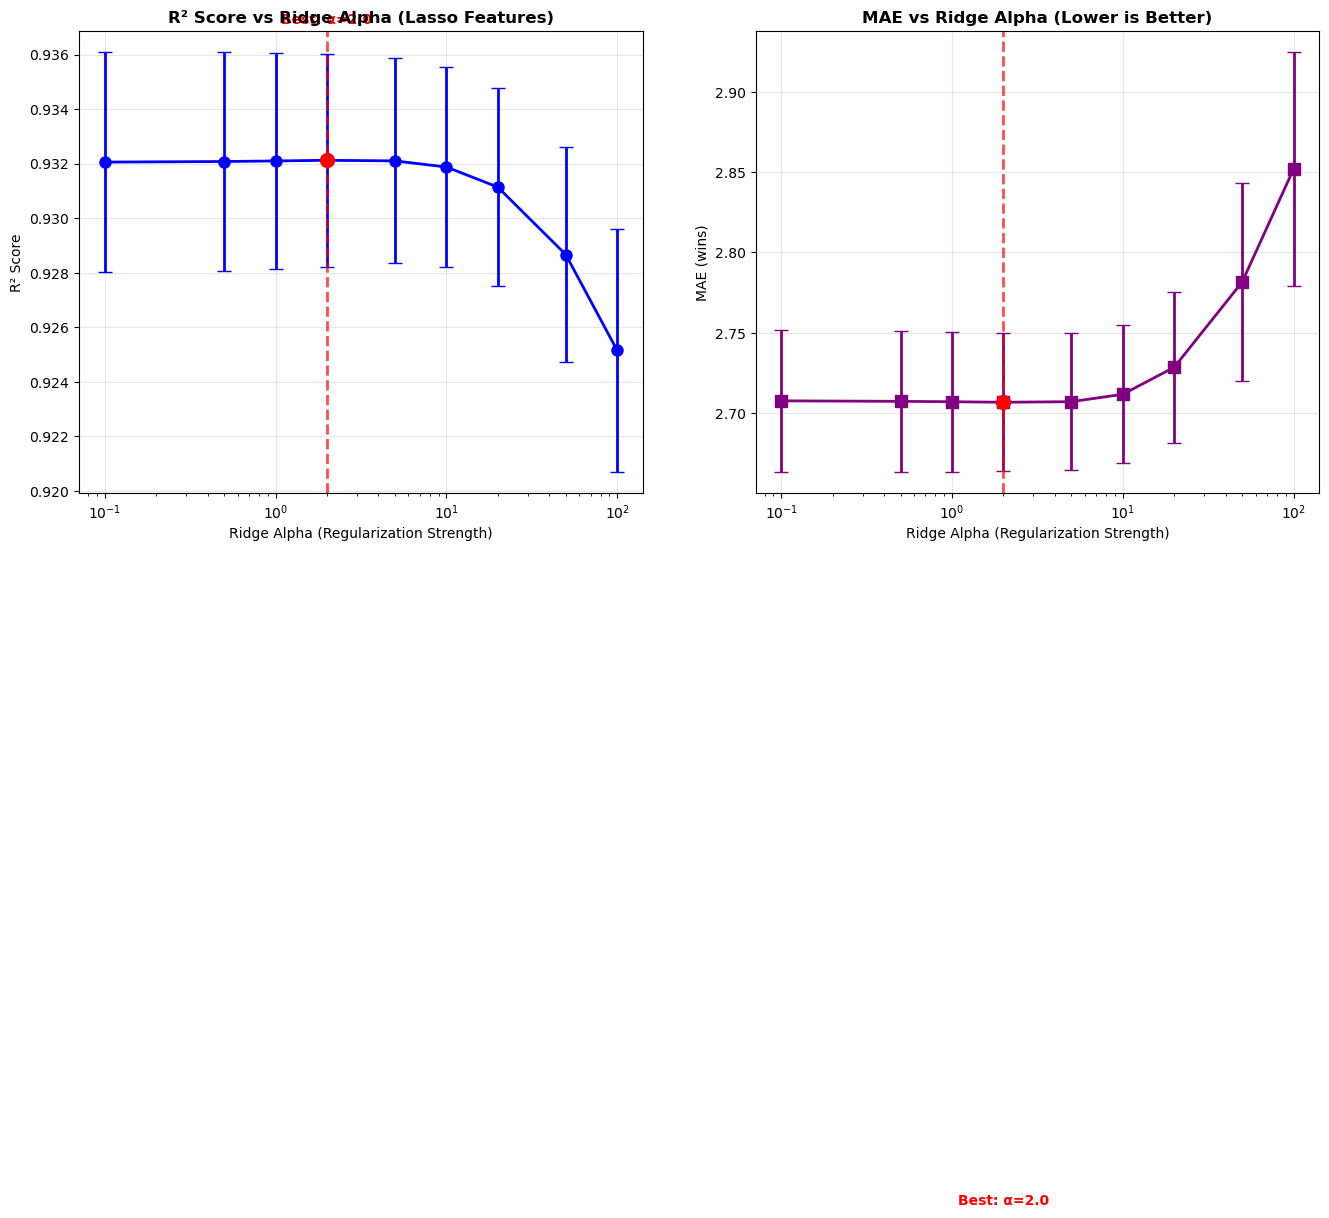


🔍 RIDGE REGULARIZATION ANALYSIS:
Best alpha: 2.0
Using 37 Lasso-selected features


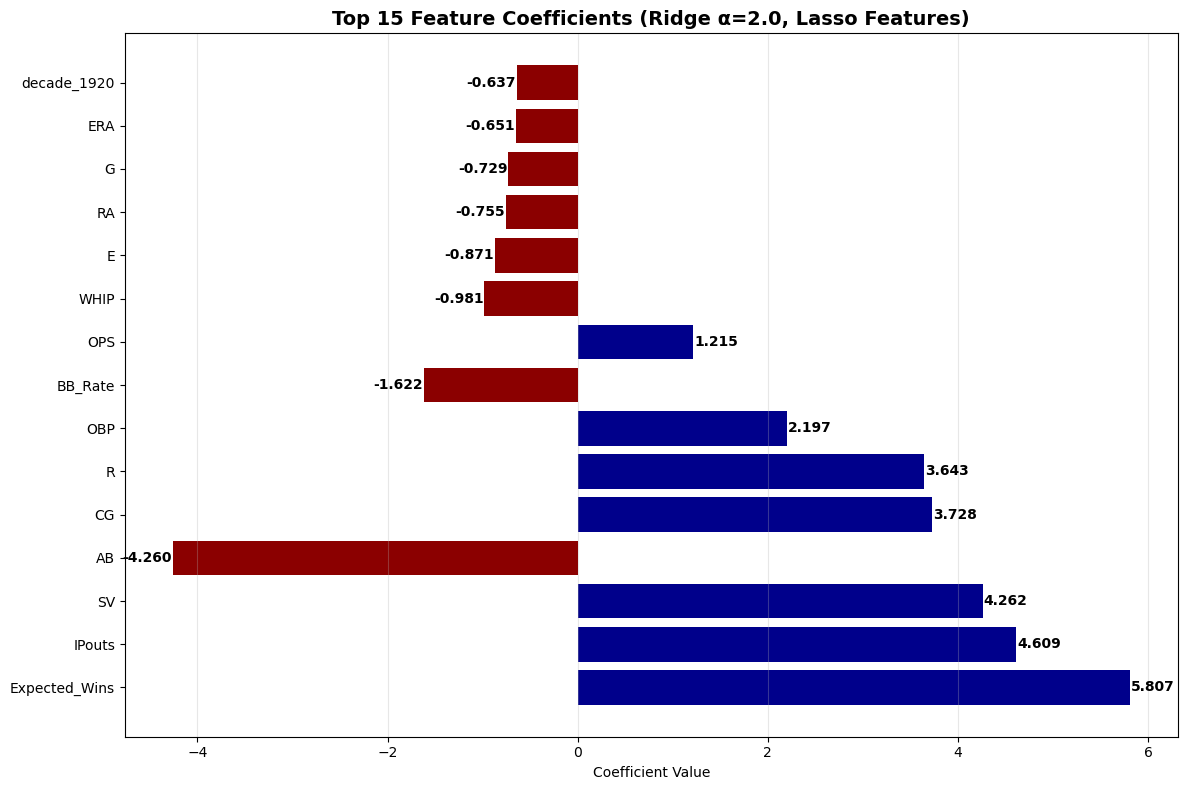


📊 REGULARIZATION STRENGTH ANALYSIS:
   α=  0.1: ||coefficients||₂ = 11.794
   α=  1.0: ||coefficients||₂ = 11.665
   α= 10.0: ||coefficients||₂ = 10.686
   α=100.0: ||coefficients||₂ = 8.019

🎯 FINAL OPTIMIZED RIDGE MODEL:
   Best alpha: 2.0
   Expected CV R²: 0.9321
   Expected CV MAE: 2.71 wins
   Features: 37 (selected by Lasso)

✅ Optimized Ridge model is ready for predictions!
   • Lasso performed feature selection (removed 18 features)
   • Ridge provides L2 regularization on selected features
   • Best of both worlds: feature selection + regularization


In [14]:
# Create visualization of Ridge hyperparameter tuning results
print("RIDGE TUNING VISUALIZATION WITH LASSO FEATURES")
print("="*50)

# Create plots showing R² and MAE across different alpha values
alpha_values_ridge = param_grid_ridge['ridge__alpha']
r2_scores_ridge = []
mae_scores_ridge = []
r2_stds_ridge = []
mae_stds_ridge = []

for alpha_val in alpha_values_ridge:
    # Find the result for this alpha value
    mask = results_df_ridge['param_ridge__alpha'] == alpha_val
    if mask.any():
        r2_scores_ridge.append(results_df_ridge.loc[mask, 'mean_test_r2'].iloc[0])
        r2_stds_ridge.append(results_df_ridge.loc[mask, 'std_test_r2'].iloc[0])
        mae_scores_ridge.append(-results_df_ridge.loc[mask, 'mean_test_neg_mean_absolute_error'].iloc[0])
        mae_stds_ridge.append(results_df_ridge.loc[mask, 'std_test_neg_mean_absolute_error'].iloc[0])

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² vs Alpha plot
ax1.errorbar(alpha_values_ridge, r2_scores_ridge, yerr=r2_stds_ridge, marker='o', capsize=5, linewidth=2, markersize=8, color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Ridge Alpha (Regularization Strength)')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score vs Ridge Alpha (Lasso Features)', fontsize=12, weight='bold')
ax1.grid(True, alpha=0.3)

# Highlight best alpha
best_alpha_ridge = grid_search_ridge.best_params_['ridge__alpha']
best_r2_ridge = grid_search_ridge.best_score_
ax1.axvline(x=best_alpha_ridge, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.scatter([best_alpha_ridge], [best_r2_ridge], color='red', s=100, zorder=5)
ax1.text(best_alpha_ridge, best_r2_ridge + 0.005, f'Best: α={best_alpha_ridge}', 
         ha='center', fontweight='bold', color='red')

# MAE vs Alpha plot
ax2.errorbar(alpha_values_ridge, mae_scores_ridge, yerr=mae_stds_ridge, marker='s', capsize=5, linewidth=2, markersize=8, color='purple')
ax2.set_xscale('log')
ax2.set_xlabel('Ridge Alpha (Regularization Strength)')
ax2.set_ylabel('MAE (wins)')
ax2.set_title('MAE vs Ridge Alpha (Lower is Better)', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.3)

# Highlight best alpha for MAE
best_mae_ridge = best_mae_score_ridge
ax2.axvline(x=best_alpha_ridge, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.scatter([best_alpha_ridge], [best_mae_ridge], color='red', s=100, zorder=5)
ax2.text(best_alpha_ridge, best_mae_ridge - 0.5, f'Best: α={best_alpha_ridge}', 
         ha='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Feature coefficient magnitude visualization
print(f"\n🔍 RIDGE REGULARIZATION ANALYSIS:")
print(f"Best alpha: {best_alpha_ridge}")
print(f"Using {len(lasso_selected_features)} Lasso-selected features")

# Create feature coefficient plot (Ridge doesn't zero out features, but shrinks them)
top_features_ridge = feature_importance_ridge.head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features_ridge)), top_features_ridge['coefficient'], 
                color=['darkblue' if x > 0 else 'darkred' for x in top_features_ridge['coefficient']])
plt.yticks(range(len(top_features_ridge)), top_features_ridge['feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 15 Feature Coefficients (Ridge α={best_alpha_ridge}, Lasso Features)', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, coef) in enumerate(zip(bars, top_features_ridge['coefficient'])):
    plt.text(coef + (0.01 if coef > 0 else -0.01), i, f'{coef:.3f}', 
             ha='left' if coef > 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Compare regularization strengths across different alpha values
print(f"\n📊 REGULARIZATION STRENGTH ANALYSIS:")
alpha_comparison = [0.1, 1.0, 10.0, 100.0]
ridge_norms = []

for alpha_comp in alpha_comparison:
    if alpha_comp in alpha_values_ridge:
        # Create temporary ridge with this alpha
        temp_ridge = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha_comp))
        ])
        temp_ridge.fit(X_ridge_tuning, y_ridge_tuning)
        coef_norm = np.linalg.norm(temp_ridge.named_steps['ridge'].coef_)
        ridge_norms.append(coef_norm)
        print(f"   α={alpha_comp:>5}: ||coefficients||₂ = {coef_norm:.3f}")

# Create the final optimized Ridge model
print(f"\n🎯 FINAL OPTIMIZED RIDGE MODEL:")
print(f"   Best alpha: {best_alpha_ridge}")
print(f"   Expected CV R²: {grid_search_ridge.best_score_:.4f}")
print(f"   Expected CV MAE: {best_mae_score_ridge:.2f} wins")
print(f"   Features: {len(lasso_selected_features)} (selected by Lasso)")

optimized_ridge_final = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha_ridge))
])

# Train on full dataset using Lasso-selected features
optimized_ridge_final.fit(X_ridge_tuning, y_ridge_tuning)

print(f"\n✅ Optimized Ridge model is ready for predictions!")
print(f"   • Lasso performed feature selection (removed {len(available_features) - len(lasso_selected_features)} features)")
print(f"   • Ridge provides L2 regularization on selected features")
print(f"   • Best of both worlds: feature selection + regularization")

In [16]:
print("GENERATING FINAL PREDICTIONS WITH TUNED RIDGE + LASSO FEATURES")
print("="*65)

# Use the optimized Ridge model for final predictions
print(f"Using optimized model: Ridge with α={grid_search_ridge.best_params_['ridge__alpha']}")
print(f"Using {len(lasso_selected_features)} features selected by Lasso")

# Verify test data has the same selected features
print(f"\nFeature verification:")
print(f"   Lasso selected features: {len(lasso_selected_features)}")
print(f"   Features in test set: {len([f for f in lasso_selected_features if f in test_df.columns])}")

# Prepare test data with Lasso-selected features
X_test_final_ridge = test_df[lasso_selected_features]
print(f"   Test data shape: {X_test_final_ridge.shape}")

# The optimized_ridge_final model is already trained on the full dataset
# Generate predictions on the test set
test_predictions_ridge = optimized_ridge_final.predict(X_test_final_ridge)

print(f"\nGenerated {len(test_predictions_ridge)} predictions for the test set")
print(f"Prediction range: {test_predictions_ridge.min():.2f} to {test_predictions_ridge.max():.2f} wins")
print(f"Prediction mean: {test_predictions_ridge.mean():.2f} wins")
print(f"Prediction std: {test_predictions_ridge.std():.2f} wins")

# Create submission dataframe
submission_df_ridge = pd.DataFrame({
    'ID': test_df['ID'],
    'W': test_predictions_ridge
})

print(f"\nSubmission dataframe shape: {submission_df_ridge.shape}")
print("First few predictions:")
print(submission_df_ridge.head(10))

print("\nLast few predictions:")
print(submission_df_ridge.tail(5))

# Verify no missing values
print(f"\nData validation:")
print(f"Missing values in ID: {submission_df_ridge['ID'].isnull().sum()}")
print(f"Missing values in W: {submission_df_ridge['W'].isnull().sum()}")
print(f"Unique IDs: {submission_df_ridge['ID'].nunique()}")

# Model summary for reference
print(f"\n🎯 FINAL MODEL SUMMARY:")
print(f"   Model: Tuned Ridge Regression with Lasso Feature Selection")
print(f"   Ridge alpha: {grid_search_ridge.best_params_['ridge__alpha']}")
print(f"   Expected CV R²: {grid_search_ridge.best_score_:.4f}")
print(f"   Expected CV MAE: {best_mae_score_ridge:.2f} wins")
print(f"   Features: {len(lasso_selected_features)} selected by Lasso (reduced from {len(available_features)})")
print(f"   Feature reduction: {(len(available_features) - len(lasso_selected_features))/len(available_features):.1%}")

# Compare with training set statistics for sanity check
print(f"\n📊 PREDICTION SANITY CHECK:")
print(f"   Training W range: {y_full.min():.1f} to {y_full.max():.1f} wins")
print(f"   Training W mean: {y_full.mean():.1f} wins")
print(f"   Prediction range: {test_predictions_ridge.min():.1f} to {test_predictions_ridge.max():.1f} wins")
print(f"   Prediction mean: {test_predictions_ridge.mean():.1f} wins")

# Save submission to CSV with timestamp
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename_ridge = f'submission_lasso_ridge_alpha{grid_search_ridge.best_params_["ridge__alpha"]}_{timestamp}.csv'
submission_path_ridge = SUB_DIR / submission_filename_ridge
submission_df_ridge.to_csv(submission_path_ridge, index=False)

print(f"\n💾 SUBMISSION SAVED:")
print(f"   Path: {submission_path_ridge}")
print(f"   Filename: {submission_filename_ridge}")
print(f"   Ready for Kaggle submission!")

# Final feature importance summary for Ridge with Lasso features
print(f"\n🏆 TOP FEATURES BY COEFFICIENT MAGNITUDE (RIDGE + LASSO):")
top_features_ridge_final = feature_importance_ridge.head(10)
print("-" * 60)
for i, row in top_features_ridge_final.iterrows():
    print(f"   {row['feature']:>25}: {row['coefficient']:>7.3f}")

print(f"\n✅ LASSO + RIDGE MODEL COMPLETE!")
print(f"   • Step 1: Lasso selected {len(lasso_selected_features)} most important features")
print(f"   • Step 2: Ridge applied L2 regularization (α={grid_search_ridge.best_params_['ridge__alpha']}) to selected features")
print(f"   • Result: Optimal feature selection + regularization combination")
print(f"   • Submission file saved and ready for upload")

# Show selected features for reference
print(f"\n📋 SELECTED FEATURES BY LASSO:")
for i, feature in enumerate(lasso_selected_features, 1):
    lasso_coef = lasso_coefficients[available_features.index(feature)]
    ridge_coef = ridge_coefficients[lasso_selected_features.index(feature)]
    print(f"   {i:2d}. {feature:>25} (Lasso: {lasso_coef:>6.3f}, Ridge: {ridge_coef:>6.3f})")

GENERATING FINAL PREDICTIONS WITH TUNED RIDGE + LASSO FEATURES
Using optimized model: Ridge with α=2.0
Using 37 features selected by Lasso

Feature verification:
   Lasso selected features: 37
   Features in test set: 37
   Test data shape: (453, 37)

Generated 453 predictions for the test set
Prediction range: 44.63 to 109.81 wins
Prediction mean: 79.06 wins
Prediction std: 12.08 wins

Submission dataframe shape: (453, 2)
First few predictions:
     ID          W
0  1756  69.363941
1  1282  74.507839
2   351  84.454763
3   421  87.046313
4    57  93.271675
5  1557  97.683670
6   846  79.417316
7  1658  83.940647
8   112  72.584977
9  2075  83.553491

Last few predictions:
       ID          W
448   651  68.435785
449     9  68.081710
450  1518  99.910671
451  2101  81.364565
452   451  66.563296

Data validation:
Missing values in ID: 0
Missing values in W: 0
Unique IDs: 453

🎯 FINAL MODEL SUMMARY:
   Model: Tuned Ridge Regression with Lasso Feature Selection
   Ridge alpha: 2.0
   Ex